### Lightbgm & 폰트 설치

In [ ]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,166 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline


In [ ]:
import lightgbm
lightgbm.__version__

'3.3.2'

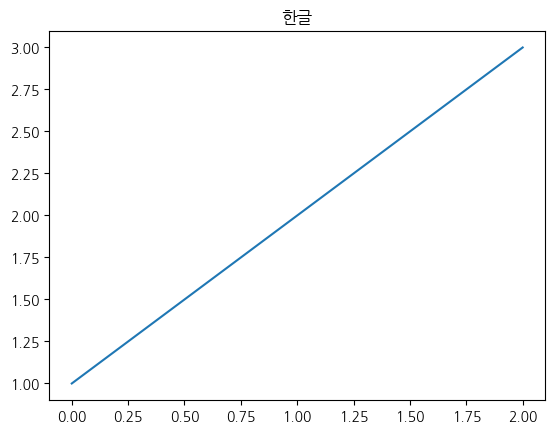

In [ ]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

### 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 데이터셋 및 라이브러리 불러오기
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [ ]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head(1)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189


### 모델 학습

In [ ]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현
vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

# 훈련데이터, 테스트데이터 분리
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state = 1)

# 학습, 예측, 평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9561


In [ ]:
# 개별 모델의 학습/예측/평가 확인(반복문 사용)

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__  # 각 모델의 이름 가져오기

    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

LogisticRegression 정확도: 0.9561
KNeighborsClassifier 정확도: 0.9474


## 데이터 불러오기

In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()

    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')

    # 중복 feature 명에 대해 원본 feature_1, _2 추가
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis = 1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
    return new_feature_name_df


In [ ]:
import pandas as pd

def get_human_dataset( ):

    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    DATA_PATH = '/content/drive/MyDrive/멀티캠퍼스/data'
    feature_name_df = pd.read_csv(DATA_PATH + '/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv(DATA_PATH + '/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv(DATA_PATH + '/human_activity/test/X_test.txt',sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv(DATA_PATH + '/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv(DATA_PATH + '/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [ ]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset() 이용해서 학습/테스트용 데이터프레임 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습
rf_clf = RandomForestClassifier(n_estimators=100, random_state = 1, max_depth = 8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print("정확도: ", accuracy)

정확도:  0.9219545300305395


In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [50, 100, 150],
    'max_depth' : [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 16]
}

# RandomForestClassifier 객체 생성 후, GridSearchCV
rf_clf = RandomForestClassifier(random_state = 1, n_jobs = -1)  # 병렬처리
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs=-1) # 병렬처리
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))


최적 하이퍼 파라미터:
 {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
최고 예측 정확도: 0.9609


## GBM
- 단점 : 속도가 매우 느림
- 보완 : XGboost, LightGBM

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings

warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = get_human_dataset()

#### 수행시간 측정

In [ ]:
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print("수행시간: {0:.1f}초" .format(time.time() - start_time))

수행시간: 1025.0초


## XGBoost
- https://xgboost.readthedocs.io/en/stable/
- 과적합 방지 : https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html

In [ ]:
import xgboost
print(xgboost.__version__)

1.7.6


- 228 p
    - 파이썬 래퍼 XGBoost 하이퍼 파라미터
        - xgboost.DMatrix() 데이터를 변환해서 사용한다

#### STEP 0. 라이브러리 불러오기, 환경설정

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#### STEP 1. 데이터셋 불러오기

In [ ]:
dataset = load_breast_cancer()
features = dataset.data # 독립변수
labels = dataset.target # 종속변수

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


#### STEP 2. 훈련데이터와 테스트데이터로 분리
- X_tr : 훈련데이터 80%
    - X_val : 검증데이터 (훈련데이터의 10%, 나머지 90%가 실제 훈련데이터)
- X_test : 테스트데이터 20%

In [ ]:
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


#### STEP 3. 데이터 변환(XGBoost 객체)

In [ ]:
# p.234 [🚩핵심코드]
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
params = {
    'max_depth': 3,
    'eta':0.05,
    'objective':'binary:logistic',
    'eval_metric':'logloss'  # 오차
}

num_rounds = 300

# 236p. 훈련 / 검증 데이터셋
eval_list = [(dtr, 'train'), (dval, 'eval')]

xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds,
                      early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

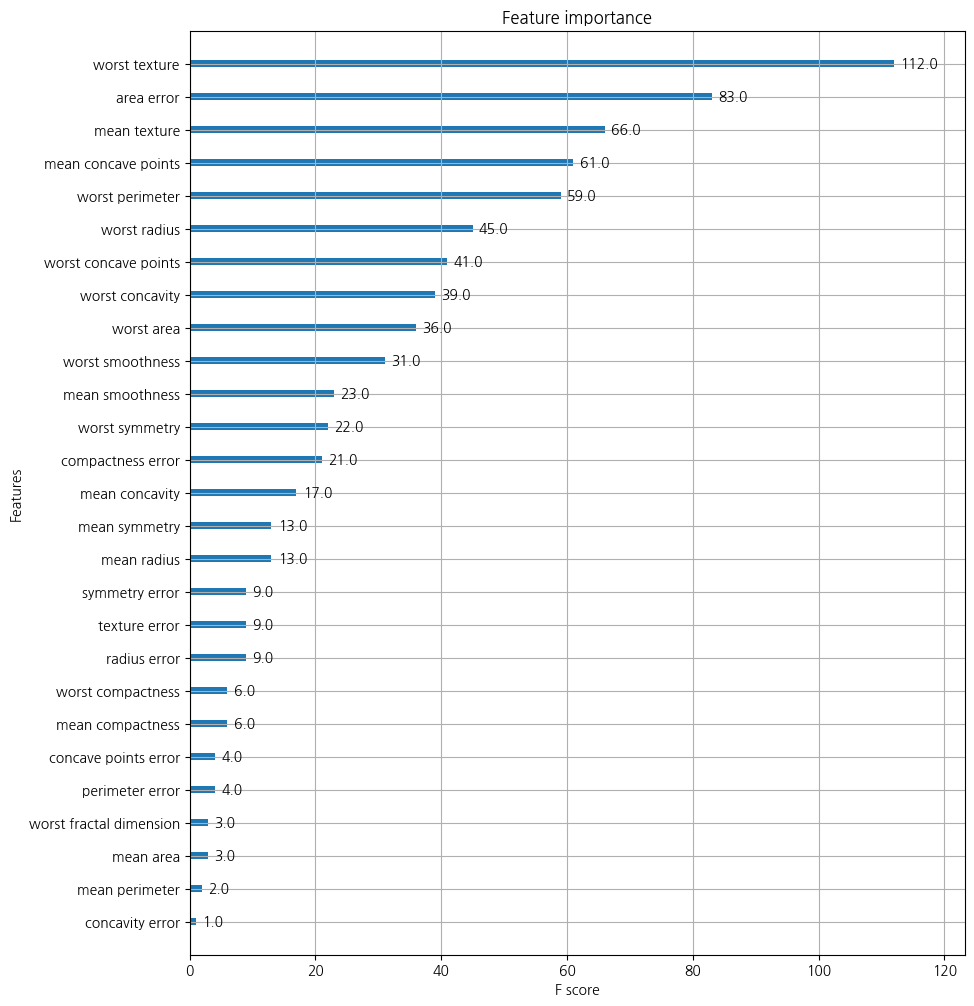

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb_model, ax=ax)

## LightGBM

#### STEP 0. 환경설정

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#### STEP 1. 데이터셋 불러오기

In [ ]:
dataset = load_breast_cancer()
features = dataset.data # 독립변수
labels = dataset.target # 종속변수

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = y_label

#### STEP 2. 데이터 분리

In [ ]:
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.1, random_state = 156)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)


#### STEP 3. 모델링
- 사이킷런 래퍼 형태로 진행
- 미니과제 : python 래퍼 형태로 변경해서 코드 완성

In [ ]:
# 251p

lbgm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# 조기 중단 수행 가능
evals = [(X_tr, y_tr), (X_val, y_val)]
lbgm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set = evals,
                 verbose = True)

preds = lbgm_wrapper.predict(X_test)
pred_proba = lbgm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.620353	valid_1's binary_logloss: 0.647246
[2]	training's binary_logloss: 0.583961	valid_1's binary_logloss: 0.611136
[3]	training's binary_logloss: 0.551164	valid_1's binary_logloss: 0.579893
[4]	training's binary_logloss: 0.521415	valid_1's binary_logloss: 0.551315
[5]	training's binary_logloss: 0.494306	valid_1's binary_logloss: 0.525797
[6]	training's binary_logloss: 0.468135	valid_1's binary_logloss: 0.502377
[7]	training's binary_logloss: 0.444167	valid_1's binary_logloss: 0.480596
[8]	training's binary_logloss: 0.423093	valid_1's binary_logloss: 0.461496
[9]	training's binary_logloss: 0.401745	valid_1's binary_logloss: 0.443786
[10]	training's binary_logloss: 0.383176	valid_1's binary_logloss: 0.429351
[11]	training's binary_logloss: 0.364724	valid_1's binary_logloss: 0.414741
[12]	training's binary_logloss: 0.348665	valid_1's binary_logloss: 0.402674
[13]	training's binary_logloss: 0.332613	valid_1's binary_logloss: 0.38964
[14]	training's binary

#### STEP 5. 평가

In [1]:
get_clf_eval(y_test, preds, pred_probs)

NameError: ignored